#TODO
1. splitten op jaartal voordat Xtrain en Ytrain gemaakt worden (2015 train en dan 2016 test maken)
2. je mag alleen data gebruiken die tot de XOR-split gebeurt is
3. van te voren een split kiezen (accept/reject) doctype komt niet altijd vaker voor in dezelfde trace
4. risk factor is altijd 1

In [173]:
import json
import sys
from pathlib import Path
import os
import pickle
import pandas as pd
from copy import deepcopy
from tqdm import tqdm
import json
from pathlib import Path
import numpy as np

module_path = str(Path.cwd().parents[0] / "Q1")
if module_path not in sys.path:
    sys.path.append(module_path)
import utils

module_path2 = str(Path.cwd().parents[0] / "Q4/PyDREAM/pydream")
if module_path2 not in sys.path:
    sys.path.append(module_path2)
    
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_import_factory
from pm4py.objects.petri.exporter.exporter import pnml as pnml_exporter
from pm4py.objects.petri.importer.importer import pnml as pnml_importer
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
# from pm4py.objects.log.importer.csv import importer as csv_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.util import get_log_representation

from LogWrapper import LogWrapper
from EnhancedPN import EnhancedPN
from predictive.nap.NAP import NAP
from predictive.nap.NAPr import NAPr
from util.TimedStateSamples import loadTimedStateSamples

from pm4py.visualization.petrinet import visualizer as pn_vis_factory
from graphviz import *

# Import utils.py from Q1 folder
module_path = str(Path.cwd().parents[0] / "Q1")
if module_path not in sys.path:
    sys.path.append(module_path)
import utils

from pm4py.visualization.petrinet import visualizer
from pm4py.algo.enhancement.decision import algorithm as decision_mining

In [174]:
def create_activity_categories(dataframe):
    start = ["income", "initialize", "begin", "create"]
    during = ["editing", "performed", "calculate", "decide", "change", "correction", "revoke", "clear", "valid", "save", "plan", "prepare", "original", "check", "offline", "insert", "remove", "pre-check"]
    end = ["finish", "abort", "discard", "withdraw", "approve", "refuse"]
    activity_type = ["Payment", "Entitlement", "Control", "Parcel", "Geo", "Reference", "Department", "Inspection"]
    parsed = []
    not_parsed = []
    mapping = dict()
    to_parse = deepcopy(dataframe["Activity"].unique())

    for idx, item in enumerate(tqdm(to_parse)):
        filtered = False

        for word in start:
            if word in item:
                for activity in activity_type:
                    if activity in item:
                        filtered = True
                        mapping[to_parse[idx]] = "Start_" + activity
                        parsed.append(to_parse[idx])
                        break

        for word in during:
            if word in item:
                for activity in activity_type:
                    if activity in item:
                        filtered = True
                        mapping[to_parse[idx]] = "During_" + activity
                        parsed.append(to_parse[idx])
                        break

        for word in end:
            if word in item:
                for activity in activity_type:
                    if activity in item:
                        filtered = True
                        mapping[to_parse[idx]] = "End_" + activity
                        parsed.append(to_parse[idx])
                        break

        if not filtered:
            not_parsed.append(to_parse[idx])

    if len(not_parsed) > 0:
        raise ValueError(f"Not all activities were correctly categorized as 'start', 'during', 'end' or were not given an 'activity_type'. \n It concerns the following items: \n \n {not_parsed}")
    
    total = len(set(val for dic in [mapping] for val in mapping.values()))
    print(f"There are {total} categories remaining.")
    
    return mapping

def add_mapping_to_df(dataframe):
    for idx, item in enumerate(tqdm(dataframe.values)):
        dataframe.at[idx, "Categorized_Activity"] = mapping[dataframe.loc[idx]["Activity"]]
        
def save_results(miner_name, filename, results):
    with open(filename, "w") as file:
        file.write(miner_name)
        file.write("\n")
        file.write("Fitness: " + str(results[0]))
        file.write("\n")
        file.write("Generalization: " + str(results[1]))
        file.write("\n")
        file.write("Simplicity: " + str(results[2]))
        file.write("\n")

def analyze_petri(log, miner_name, net, initial_marking, final_marking, filter_type="doctype"):
    start = time.perf_counter()

    # fitness based on toked-based replay
    fitness = replay_fitness_evaluator.apply(log, net, initial_marking, final_marking, 
              variant=replay_fitness_evaluator.Variants.TOKEN_BASED,
              parameters={constants.PARAMETER_CONSTANT_ACTIVITY_KEY: "Categorized_Activity"})
    
    gc.collect()

    # precision based on token-based replay
    #prec = precision_evaluator.apply(df2, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE, parameters={constants.PARAMETER_CONSTANT_ACTIVITY_KEY: "Categorized_Activity"})

    #print(f"[ Finished Precision metric: {time.perf_counter() - start} sec]")

    # collect garbage
    #gc.collect()

    # generalization based on token-based replay
    gen = generalization_evaluator.apply(log, net, initial_marking, final_marking, parameters={constants.PARAMETER_CONSTANT_CASEID_KEY: 'case:concept:name', constants.PARAMETER_CONSTANT_ACTIVITY_KEY: "Categorized_Activity", constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})
                                         

    # collect garbage
    gc.collect()

    print(f"[ Finished Generalization metric: {time.perf_counter() - start} sec]")

    # simplicity measured by the inverse arc degree
    simp = simplicity_evaluator.apply(net)

    print(f"[Finished: {time.perf_counter() - start}]")
    results = [fitness, gen, simp]
    filename = miner_name + "_results.txt"
    
    # save petri net
    petrinet_name = miner_name + ".pnml"
    print(f"[Saving petrinet of {miner_name} to file :{petrinet_name}_doctype]")
    pnml_exporter.export_net(net, initial_marking, petrinet_name)
    
    # save results
    print(f"[Saving {miner_name} to file :{filename}_doctype]")
    save_results(miner_name, filename, results)

### Steps to reproduce
1. pip3 install -r requirements.txt in the PyDream folder (installation for ortools will fail)
2. pip3 install ortools==7.5.7466
3. 

One important task in customer journey optimization is    predicting the next activity in the journey. It helps for instance in preparing the business owner for the next interaction point with the application. In this part, you will start from one of the process models from Part I of your choice. 

1. Select two meaningful XOR splits in the process model you choose from Part 
    1. “meaningful” selection of the XOR depends on how you will be able to motivate it from the business perspective. You can select XOR splits with more than two outgoing arcs.

In [175]:
print("Loading FILTERED parquet version of original dataframe (need to run first part of 'transform_and_filter_df.ipynb' for this). ")
df = utils.load_parquet_filtered()
df["Categorized_Activity"] = ""
df = df.reset_index()

# load undesired info log 
log = utils._load_pickle("../dataset/complete_undesired_outcomes_df")

# merge dataframes
df = pd.merge(log, df)

# Filter on Undesired Outcome 1
df_1 = df.loc[df['Undesired Outcome 1'] == True]

# remove some columns and rename
#df_1 = df_1[['Case ID', "Activity", 'time:timestamp', "Categorized_Activity", "doctype", "concept:name"]].sort_values('time:timestamp').rename(columns={"Case ID": "case:concept:name"})
df_1 = df_1.rename(columns={"Case ID": "case:concept:name"})
# reset index for changes
df_1 = df_1.reset_index()

Loading FILTERED parquet version of original dataframe (need to run first part of 'transform_and_filter_df.ipynb' for this). 


### Steps to reproduce
1. pip3 install -r requirements.txt in the PyDream folder (installation for ortools will fail)
2. pip3 install ortools==7.5.7466
3. 

One important task in customer journey optimization is    predicting the next activity in the journey. It helps for instance in preparing the business owner for the next interaction point with the application. In this part, you will start from one of the process models from Part I of your choice. 

1. Select two meaningful XOR splits in the process model you choose from Part 
    1. “meaningful” selection of the XOR depends on how you will be able to motivate it from the business perspective. You can select XOR splits with more than two outgoing arcs.

In [176]:
print("Loading FILTERED parquet version of original dataframe (need to run first part of 'transform_and_filter_df.ipynb' for this). ")
df = utils.load_parquet_filtered()
df["Categorized_Activity"] = ""
df = df.reset_index()

# load undesired info log 
log = utils._load_pickle("../dataset/complete_undesired_outcomes_df")

# merge dataframes
df = pd.merge(log, df)

# Filter on Undesired Outcome 1
df_1 = df.loc[df['Undesired Outcome 1'] == True]

# remove some columns and rename
#df_1 = df_1[['Case ID', "Activity", 'time:timestamp', "Categorized_Activity", "doctype", "concept:name"]].sort_values('time:timestamp').rename(columns={"Case ID": "case:concept:name"})
df_1 = df_1.rename(columns={"Case ID": "case:concept:name"}).sort_values('time:timestamp')
# reset index for changes
df_1 = df_1.reset_index()

Loading FILTERED parquet version of original dataframe (need to run first part of 'transform_and_filter_df.ipynb' for this). 


In [177]:
# create the mapping
mapping = create_activity_categories(df_1)

# append column with new mapping to our old dataframe
add_mapping_to_df(df_1)

#output first 5 results
df_1.tail()

  5%|▌         | 535/10071 [00:00<00:01, 5340.32it/s]

There are 21 categories remaining.


100%|██████████| 10071/10071 [00:01<00:00, 5669.17it/s]


,level_0,case:concept:name,Undesired Outcome 2,Undesired Outcome 1,Both,Normal,index,Activity,org:resource,time:timestamp,...,activity,concept:name,docid,doctype,eventid,lifecycle:transition,note,subprocess,success,Categorized_Activity
10066,38426,d6e1ac5882a446e3,False,True,False,False,1802734,Inspection-On-Site-save,f8da29,2018-01-19 07:53:07.679000+00:00,...,save,save,-144109123420021491,Inspection,-1.441091e+17,complete,none,On-Site,True,During_Inspection
10067,38427,d6e1ac5882a446e3,False,True,False,False,1802735,Inspection-On-Site-save,f8da29,2018-01-19 07:55:14.311000+00:00,...,save,save,-144109123420021491,Inspection,-1.441091e+17,complete,none,On-Site,True,During_Inspection
10068,38428,d6e1ac5882a446e3,False,True,False,False,1802736,Inspection-On-Site-save,f8da29,2018-01-19 07:55:22.173000+00:00,...,save,save,-144109123420021491,Inspection,-1.441091e+17,complete,none,On-Site,True,During_Inspection
10069,38429,d6e1ac5882a446e3,False,True,False,False,1802737,Inspection-On-Site-performed offline,f8da29,2018-01-19 07:56:37.075000+00:00,...,performed offline,performed offline,-144109123420021491,Inspection,-1.441091e+17,complete,none,On-Site,True,During_Inspection
10070,38430,d6e1ac5882a446e3,False,True,False,False,1802738,Inspection-On-Site-finish editing,f8da29,2018-01-19 07:56:52.811000+00:00,...,finish editing,finish editing,-144109123420021491,Inspection,-1.441091e+17,complete,none,On-Site,True,End_Inspection


In [328]:
def filter_df_on_year(dataframe, year):
    """Returns filtered dataframe"""
    mask = (dataframe["time:timestamp"] < str(year)).to_numpy()
    return dataframe[mask]

def filter_df_on_end_place(dataframe, activity):
    

In [178]:
# csv = df_1.to_csv("df_1.csv")

# #event_stream = csv_importer.import_event_stream(os.path.join("tests", "input_data", "running-example.csv"))
log_csv = pd.read_csv('df_1.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
log_csv = log_csv.sort_values('time:timestamp')
event_log = log_converter.apply(log_csv)

# # automatic feature selection on the event log
# """Results in 10 features that will be one hot encoded and used to traint the model"""
# """ 8 out of 21 categories were considered important, together with index (so not timestamp) which is because
# the traces were already sorted on timestamp. Lastly the Unnamed 0 feature from the event log. 

# """
# # data, feature_names = get_log_representation.get_default_representation(event_log)
# # feature_names

In [179]:
# generate a list of concept names
""" Results in 36 unique concept:names"""
activity_names = []
for trace in event_log:
    for event in trace:
        if event["activity"] in activity_names:
            continue
        else:
            activity_names.append(event['activity'])

In [180]:
"""Per case, add trace information to the dictionary consisting of:
    1. Young farmer
    2. Area
    3. Risk Factor
    4. Number of parcels
    5. Small famer
    
    Zijn al op tijd gesorteerd op time:timestamp bij het inladen van de dictionary
    
    Current Mapping:
    [0: timestamp, 
     1: activity, 
     2: identifier, 
     3: categorized_activity, 
     4: young_farmer, 
     5: area, 
     6: risk_factor, 
     7: number_parcels, 
     8: small_farmer,
     9: previous_activity,
     10: next_activity]
"""

case_dict = {}
df_1["Previous_Activity_OneHot"] = ""
df_1["Next_Activity_OneHot"] = ""
df_1["young_farmer"] = 0

for idx, row in tqdm(df_1.iterrows()):
    young_farmer = 1 if row['(case) young farmer'] == True else 0
    area = row['(case) area']
    risk_factor = row['(case) risk_factor']
    number_parcels = row['(case) number_parcels']
    small_farmer = row['(case) small farmer']
    timestamp = row['time:timestamp']
    activity = row['activity']
    identifier = row["level_0"]
    categorized_activity = row["Categorized_Activity"]
    
    data = [timestamp, activity, identifier, categorized_activity, young_farmer, 
            area, risk_factor, number_parcels, small_farmer]
    
    if row["case:concept:name"] in case_dict.keys():
        case_dict[row["case:concept:name"]].append(data)
    else:
        case_dict[row["case:concept:name"]] = []
        case_dict[row["case:concept:name"]].append(data)

10071it [00:01, 5847.19it/s]


In [181]:
"""Add one-hot for previous activity"""
for sth, case in enumerate(tqdm(case_dict)):
    for idx, event in enumerate(case_dict[case]):
        if idx == 0:
            previous_activity = [0 for i in range(36)]
        else:
            previous_activity = [1 if case_dict[case][idx-1][1] == value else 0 for value in activity_names]
        event.append(previous_activity)

100%|██████████| 184/184 [00:00<00:00, 3320.05it/s]


In [182]:
"""Add one-hot for next activity"""
for sth, case in enumerate(tqdm(case_dict)):
    for idx, event in enumerate(case_dict[case]):
        if idx == len(case_dict[case])-1:
            next_activity = [0 for i in range(36)]
        else:
            next_activity = [1 if case_dict[case][idx+1][1] == value else 0 for value in activity_names]
        event.append(next_activity)

100%|██████████| 184/184 [00:00<00:00, 3668.02it/s]


In [183]:
"""Add one-hot previous, next and young-farmer binary to the dataframe"""
for case_id in tqdm(df_1["case:concept:name"].unique()):
    for idx in df_1.index[df_1["case:concept:name"] == case_id]:
        for event in case_dict[case_id]:
            if event[2] == df_1.loc[idx]["level_0"]:
                df_1.at[idx, "Previous_Activity_OneHot"] = event[-2]
                df_1.at[idx, "Next_Activity_OneHot"] = event[-1]
                df_1.at[idx, "young_farmer"] = 1 if event[4] else 0

100%|██████████| 184/184 [01:42<00:00,  1.80it/s]


In [299]:
df_1.loc[df_1["case:concept:name"] == "99706b163f66b8ab"]

,level_0,case:concept:name,Undesired Outcome 2,Undesired Outcome 1,Both,Normal,index,Activity,org:resource,time:timestamp,...,doctype,eventid,lifecycle:transition,note,subprocess,success,Categorized_Activity,Previous_Activity_OneHot,Next_Activity_OneHot,young_farmer
0,25616,99706b163f66b8ab,True,True,True,False,761800,Payment application-Application-mail income,0;n/a,2015-04-15 00:00:00+00:00,...,Payment application,NaN,complete,none,Application,True,Start_Payment,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
11,25618,99706b163f66b8ab,True,True,True,False,761802,Payment application-Application-mail valid,0;n/a,2015-04-28 00:00:00+00:00,...,Payment application,NaN,complete,none,Application,True,During_Payment,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
14,25617,99706b163f66b8ab,True,True,True,False,761801,Entitlement application-Main-mail valid,0;n/a,2015-04-28 00:00:00+00:00,...,Entitlement application,NaN,complete,none,Main,True,During_Entitlement,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
15,25619,99706b163f66b8ab,True,True,True,False,761803,Entitlement application-Main-mail valid,0;n/a,2015-04-28 00:00:00+00:00,...,Entitlement application,NaN,complete,none,Main,True,During_Entitlement,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
368,25622,99706b163f66b8ab,True,True,True,False,761806,Parcel document-Main-finish editing,Document processing automaton,2015-06-15 08:18:04+00:00,...,Parcel document,-1.800866e+16,complete,none,Main,True,End_Parcel,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,25686,99706b163f66b8ab,True,True,True,False,761870,Payment application-Application-decide,822fb7,2016-01-27 11:22:31.696000+00:00,...,Payment application,-1.260950e+17,complete,none,Application,True,During_Payment,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0
2393,25687,99706b163f66b8ab,True,True,True,False,761871,Payment application-Application-insert document,76f30e,2016-01-27 11:22:56.050000+00:00,...,Payment application,-1.260950e+17,complete,notification for applicant,Application,True,During_Payment,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2394,25688,99706b163f66b8ab,True,True,True,False,761872,Payment application-Main-save,76f30e,2016-01-27 11:25:37.604000+00:00,...,Payment application,-1.260950e+17,complete,none,Main,True,During_Payment,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2531,25689,99706b163f66b8ab,True,True,True,False,761873,Payment application-Application-begin payment,DP-Z,2016-01-29 09:24:08.792000+00:00,...,Payment application,-1.800858e+16,complete,automatic during payment,Application,True,Start_Payment,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [185]:
df_2 = df_1[['Case ID', 'youngFarmer', "activity", "area", "riskFactor", "young_farmer", "Previous_Activity_OneHot"]].rename(
    columns={'(case) risk_factor': "riskFactor", '(case) area':"area", '(case) number_parcels':"parcels", 
             '(case) young farmer':"youngFarmer", 
             '(case) small farmer':"smallFarmer", "Case ID":"case:concept:name"}) # , "parcels", "activity", "Previous_Activity_OneHot", "Next_Activity_OneHot"
df_2.head()

KeyError: "['area', 'Case ID', 'youngFarmer', 'riskFactor'] not in index"

In [290]:
for i in df_1[:1].iterrows():
    print(i[1]["activity"])
#     if i["Previous_Activity_OneHot"][0] == [0 for i in range(36)]:
#         print(i)

mail income


In [213]:
X = df_1[['(case) risk_factor', '(case) area', '(case) number_parcels',  'young_farmer']].to_numpy(dtype=object)
# .rename(
#     columns={'(case) risk_factor': "riskFactor", '(case) area':"area", '(case) number_parcels':"parcels", 
#              '(case) young farmer':"youngFarmer", "case:concept:name":"Case ID", 
#              '(case) small farmer':"smallFarmer"}).to_numpy() #"Previous_Activity_OneHot",
Y = df_1[["activity"]].to_numpy(dtype=object)

In [259]:
import numpy.ma as ma
arr = range(0, 36)
newY = []
for idx, i in enumerate(Y):
    ma_arr = ma.masked_array(arr, mask=df_1["Previous_Activity_OneHot"][idx])
    if len(ma_arr.data[ma_arr.mask]) == 0:
        newY.append()
    
ma_arr = ma.masked_array(arr, mask=df_1["Previous_Activity_OneHot"][3446])

In [273]:
ma_arr = ma.masked_array(arr, mask=df_1["Previous_Activity_OneHot"][36])
ma_arr.data[ma_arr.mask]

array([], dtype=int64)

In [296]:
X[0]

array([1.0, 3.4104, 3.0, 0.0], dtype=object)

## Model Training & Prediction

In [208]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [209]:
values = array(activity_names)

In [210]:
# define the model
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/100


ValueError: setting an array element with a sequence.

In [144]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

[21 22 15  4 19 25 33 18  6 26  0 23  7 20 13 31 29  5 16  1  9 34 14 35
 27 24  8 32 12 30  3 10 28  2 17 11]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['mail income']


In [150]:
X_train = X[:10000]
Y_train = Y[:10000]
X_test = X[10000:]
Y_test = Y[10000:]

In [ ]:
Gebruik DT --> 
has

In [135]:
model = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=9, C=10.0)
model.fit(X_train, Y_train)

ValueError: setting an array element with a sequence.

In [129]:
model.predict(X_test, Y_test)

TypeError: predict() takes 2 positional arguments but 3 were given

In [106]:
print(classification_report(Y, model.predict(X)))

                           precision    recall  f1-score   support

           abort external       0.00      0.00      0.00        18
            abort payment       0.00      0.00      0.00        28
                  approve       0.00      0.00      0.00         2
begin admissibility check       0.00      0.00      0.00        13
            begin editing       0.00      0.00      0.00      1379
            begin payment       0.00      0.00      0.00       130
       begin preparations       0.00      0.00      0.00        53
                calculate       0.23      0.98      0.38      2347
           cancel offline       0.00      0.00      0.00         4
                    check       0.00      0.00      0.00        30
      check admissibility       0.00      0.00      0.00         9
                    clear       0.00      0.00      0.00        15
                   create       0.00      0.00      0.00       177
                   decide       0.00      0.00      0.00     

/home/rowan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# load the heuristics miner petrinet from Q1
net, initial_marking, final_marking = pnml_importer.import_net("../Q1/inductive_miner_undesired_outcome_2.pnml")

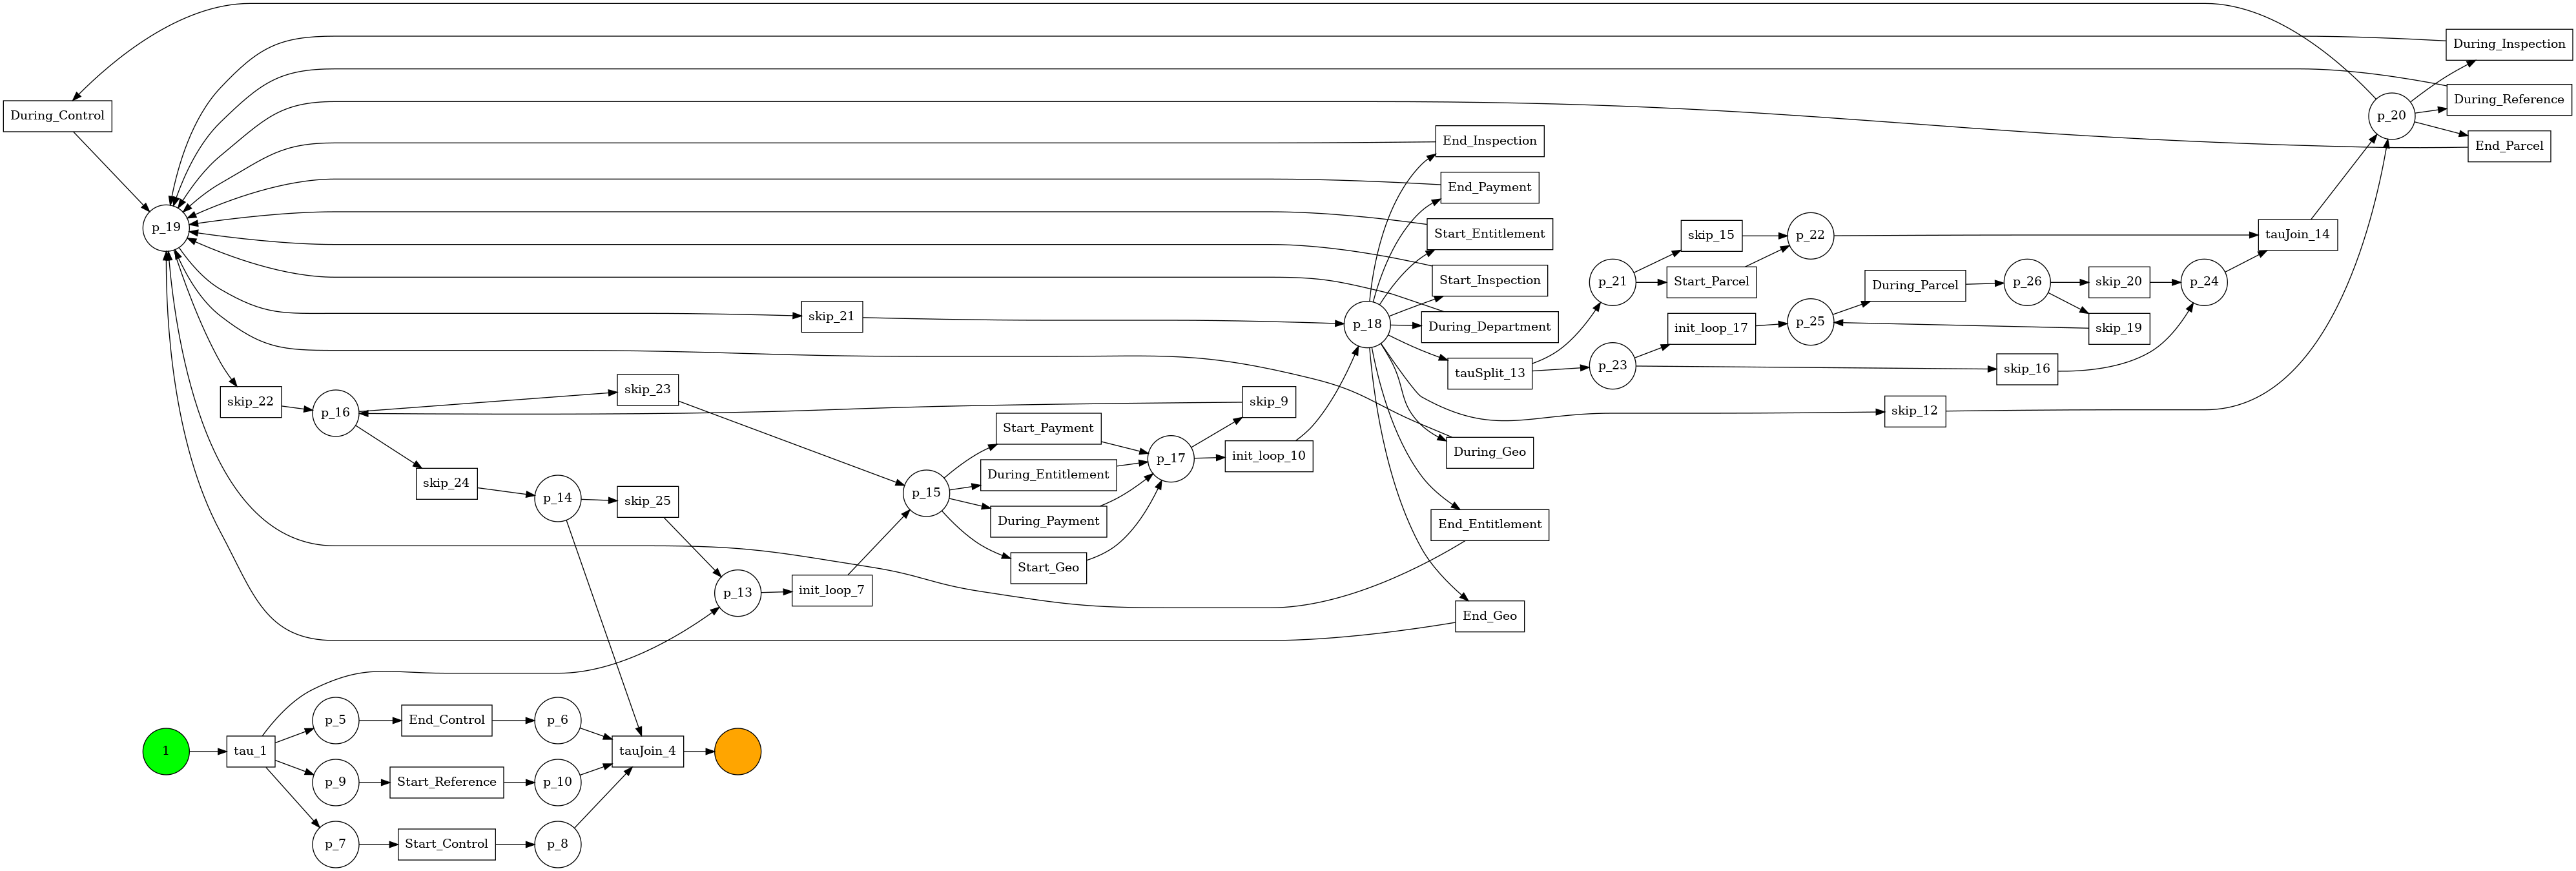

In [35]:
gviz = visualizer.apply(net, initial_marking, final_marking, parameters={visualizer.Variants.WO_DECORATION.value.Parameters.DEBUG: True})
visualizer.view(gviz)

# Decision tree

In [62]:
X, y, class_names = decision_mining.apply(df_2, net, initial_marking, final_marking, decision_point="p_15")

KeyError: "None of [Index(['riskFactor', 'area', 'young_farmer'], dtype='object')] are in the [columns]"

# PyDREAM Library

In [ ]:
# Save the one-hot encoding for use in the model
def convert_ndarray_to_list(array, path='model-path/MODEL-NAME_nap_onehotdict.json'):
    lists = array.tolist()
    Path(path).touch(exist_ok=True)
    with open(path, "w") as file:
        json.dump(lists, file)
        
convert_ndarray_to_list(data)

In [ ]:
event_log[0][1]

In [ ]:
data[6]

In [ ]:
def add_next_event(self, df):
        unique_case_ids = df["Case ID"].unique()
        for case in unique_case_ids:

df.loc[df["Case ID"] == "8b99873a6136cfa6"]

In [ ]:
net, im, fm = heuristics_miner.apply(event_log, parameters={"dependency_thresh": 0.99})
pnml_exporter.export_net(net, im, "discovered_pn.pnml")

In [293]:
# load the heuristics miner petrinet from Q1
net, initial_marking, final_marking = pnml_importer.import_net("discovered_pn.pnml")

In [ ]:
# enhance the log with decay functions
log_wrapper = LogWrapper(event_log, resources=["Categorized_Activity"])
enhanced_pn = EnhancedPN(net, initial_marking)
enhanced_pn.enhance(log_wrapper)
enhanced_pn.saveToFile("enhanced_discovered_pn.json")

In [ ]:
# open enhanced petri net
enhanced_pn = EnhancedPN(net, initial_marking, decay_function_file="enhanced_discovered_pn.json")
tss_json, tss_objs = enhanced_pn.decay_replay(log_wrapper=log_wrapper)

In [ ]:
dir(enhanced_pn.net)

In [ ]:
with open("timedstatesamples.json", 'w') as fp:
    json.dump(tss_json, fp)

In [ ]:
algo = NAPr(tss_train_file="timedstatesamples.json", tss_test_file="timedstatesamples.json", options={"n_epochs" : 10})

In [ ]:
algo.train(checkpoint_path="model-path", name="MODEL-NAME", save_results=True)

In [ ]:
# load the model
algo.loadModel(path="model-path", name="MODEL-NAME")

In [ ]:
# predict values
nap_out, string_out = algo.predict(tss_objs)

In [ ]:
tss_objs[4].data.items()
print(dir(tss_objs[4]))

In [ ]:
# visualize petri net
gviz = visualizer.apply(enhanced_pn.net, initial_marking, final_marking, parameters={visualizer.Variants.WO_DECORATION.value.Parameters.DEBUG: True})
visualizer.view(gviz)

In [ ]:
transitions = net.transitions
# print(len(transitions.difference()))
# print(dir(transitions.__xor__("hid_142")))
enhanced_pn.net.places
# for place in net.places:
#     print("\nPLACE: "+ place.name)
#     for arc in place.in_arcs:
#         print(arc.source.name, arc.source.label)

In [ ]:
tss_loaded_objs[0]

In [ ]:
tss_loaded_objs = loadTimedStateSamples("timedstatesamples.json")
nap_out, string_out = algo.predict([tss_loaded_objs[12]])

In [ ]:
if __name__== "__main__":
    log = xes_import_factory.apply('YOUR_EVENTLOG.xes')

    net, im, fm = heuristics_miner.apply(log, parameters={"dependency_thresh": 0.99})
    pnml_exporter.export_net(net, im, "discovered_pn.pnml")

    net, initial_marking, final_marking = pnml_importer.import_net("discovered_pn.pnml")

    log_wrapper = LogWrapper(log)
    enhanced_pn = EnhancedPN(net, initial_marking)
    enhanced_pn.enhance(log_wrapper)
    enhanced_pn.saveToFile("enhanced_discovered_pn.json")

    enhanced_pn = EnhancedPN(net, initial_marking, decay_function_file="enhanced_discovered_pn.json")
    tss_json, tss_objs = enhanced_pn.decay_replay(log_wrapper=log_wrapper)

    with open("timedstatesamples.json", 'w') as fp:
        json.dump(tss_json, fp)

    algo = NAP(tss_train_file="timedstatesamples.json", tss_test_file="timedstatesamples.json", options={"n_epochs" : 100})
    algo.train(checkpoint_path="model-path", name="MODEL-NAME", save_results=True)

    algo = NAP()
    algo.loadModel(path="model-path", name="MODEL-NAME")

    nap_out, string_out = algo.predict(tss_objs)

    tss_loaded_objs = loadTimedStateSamples("timedstatesamples.json")
    nap_out, string_out = algo.predict(tss_loaded_objs)

## Decision tree

In [ ]:
from pm4py.algo.enhancement.decision import algorithm as decision_mining
X, y, class_names = decision_mining.apply(event_log, enhanced_pn.net, im, fm, decision_point="discard")

In [ ]:

clf, feature_names, classes = decision_mining.get_decision_tree(df_1, net, im, fm, decision_point="pre_calculate")

In [ ]:
# create the mapping
mapping = create_activity_categories(df_1)

# append column with new mapping to our old dataframe
add_mapping_to_df(df_1)

#output first 5 results
df_1.tail()

In [ ]:
csv = df_1.to_csv("df_1.csv")

#event_stream = csv_importer.import_event_stream(os.path.join("tests", "input_data", "running-example.csv"))
log_csv = pd.read_csv('df_1.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
log_csv = log_csv.sort_values('time:timestamp')
event_log = log_converter.apply(log_csv)

# automatic feature selection on the event log
"""Results in 10 features that will be one hot encoded and used to traint the model"""
""" 8 out of 21 categories were considered important, together with index (so not timestamp) which is because
the traces were already sorted on timestamp. Lastly the Unnamed 0 feature from the event log. 

"""
# data, feature_names = get_log_representation.get_default_representation(event_log)
# feature_names

In [ ]:
event_log[0][0]

In [ ]:
info_dict = {}
for trace in event_log[0]:
    print(trace)

In [ ]:
{'Unnamed: 0': 0, 'index': 25616, 
 'Activity': 'Payment application-Application-mail income', 
 'time:timestamp': Timestamp('2015-04-15 00:00:00+0000', tz='UTC'), 
 'Categorized_Activity': 'Start_Payment', 'doctype': 'Payment application', 'concept:name': 'mail income'}

In [ ]:
totals = []
for trace in event_log:
    for event in trace:
        totals.append(event)

In [ ]:
len(totals)

In [ ]:
data[0]

In [ ]:
event_log

In [ ]:
# Save the one-hot encoding for use in the model
def convert_ndarray_to_list(array, path='model-path/MODEL-NAME_nap_onehotdict.json'):
    lists = array.tolist()
    Path(path).touch(exist_ok=True)
    with open(path, "w") as file:
        json.dump(lists, file)
        
convert_ndarray_to_list(data)

In [ ]:
event_log[0][1]

In [ ]:
data[6]

In [ ]:
def add_next_event(self, df):
        unique_case_ids = df["Case ID"].unique()
        for case in unique_case_ids:

df.loc[df["Case ID"] == "8b99873a6136cfa6"]

In [ ]:
net, im, fm = heuristics_miner.apply(event_log, parameters={"dependency_thresh": 0.99})
pnml_exporter.export_net(net, im, "discovered_pn.pnml")

In [ ]:
# load the heuristics miner petrinet from Q1
net, initial_marking, final_marking = pnml_importer.import_net("discovered_pn.pnml")

In [ ]:
# enhance the log with decay functions
log_wrapper = LogWrapper(event_log, resources=["Categorized_Activity"])
enhanced_pn = EnhancedPN(net, initial_marking)
enhanced_pn.enhance(log_wrapper)
enhanced_pn.saveToFile("enhanced_discovered_pn.json")

In [ ]:
# open enhanced petri net
enhanced_pn = EnhancedPN(net, initial_marking, decay_function_file="enhanced_discovered_pn.json")
tss_json, tss_objs = enhanced_pn.decay_replay(log_wrapper=log_wrapper)

In [ ]:
dir(enhanced_pn.net)

In [ ]:
with open("timedstatesamples.json", 'w') as fp:
    json.dump(tss_json, fp)

In [ ]:
algo = NAPr(tss_train_file="timedstatesamples.json", tss_test_file="timedstatesamples.json", options={"n_epochs" : 10})

In [ ]:
algo.train(checkpoint_path="model-path", name="MODEL-NAME", save_results=True)

In [ ]:
# load the model
algo.loadModel(path="model-path", name="MODEL-NAME")

In [ ]:
# predict values
nap_out, string_out = algo.predict(tss_objs)

In [ ]:
tss_objs[4].data.items()
print(dir(tss_objs[4]))

In [ ]:
# visualize petri net
gviz = visualizer.apply(enhanced_pn.net, initial_marking, final_marking, parameters={visualizer.Variants.WO_DECORATION.value.Parameters.DEBUG: True})
visualizer.view(gviz)

In [ ]:
transitions = net.transitions
# print(len(transitions.difference()))
# print(dir(transitions.__xor__("hid_142")))
enhanced_pn.net.places
# for place in net.places:
#     print("\nPLACE: "+ place.name)
#     for arc in place.in_arcs:
#         print(arc.source.name, arc.source.label)

In [ ]:
tss_loaded_objs[0]

In [ ]:
tss_loaded_objs = loadTimedStateSamples("timedstatesamples.json")
nap_out, string_out = algo.predict([tss_loaded_objs[12]])

In [ ]:
if __name__== "__main__":
    log = xes_import_factory.apply('YOUR_EVENTLOG.xes')

    net, im, fm = heuristics_miner.apply(log, parameters={"dependency_thresh": 0.99})
    pnml_exporter.export_net(net, im, "discovered_pn.pnml")

    net, initial_marking, final_marking = pnml_importer.import_net("discovered_pn.pnml")

    log_wrapper = LogWrapper(log)
    enhanced_pn = EnhancedPN(net, initial_marking)
    enhanced_pn.enhance(log_wrapper)
    enhanced_pn.saveToFile("enhanced_discovered_pn.json")

    enhanced_pn = EnhancedPN(net, initial_marking, decay_function_file="enhanced_discovered_pn.json")
    tss_json, tss_objs = enhanced_pn.decay_replay(log_wrapper=log_wrapper)

    with open("timedstatesamples.json", 'w') as fp:
        json.dump(tss_json, fp)

    algo = NAP(tss_train_file="timedstatesamples.json", tss_test_file="timedstatesamples.json", options={"n_epochs" : 100})
    algo.train(checkpoint_path="model-path", name="MODEL-NAME", save_results=True)

    algo = NAP()
    algo.loadModel(path="model-path", name="MODEL-NAME")

    nap_out, string_out = algo.predict(tss_objs)

    tss_loaded_objs = loadTimedStateSamples("timedstatesamples.json")
    nap_out, string_out = algo.predict(tss_loaded_objs)

## Decision tree

In [ ]:

clf, feature_names, classes = decision_mining.get_decision_tree(df_1, net, im, fm, decision_point="pre_calculate")